In [1]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal
import sys

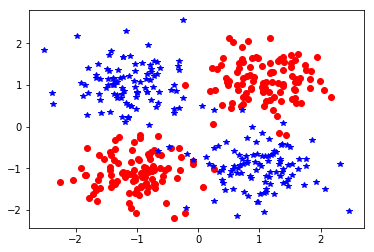

In [2]:
def generateXor_dataset(nb_sample):
    n1 = Normal(torch.Tensor([-1, -1]), torch.Tensor([0.5, 0.5]))
    n2 = Normal(torch.Tensor([1, 1]), torch.Tensor([0.5, 0.5]))
    n3 = Normal(torch.Tensor([-1, 1]), torch.Tensor([0.5, 0.5]))
    n4 = Normal(torch.Tensor([1, -1]), torch.Tensor([0.5, 0.5]))
    data = []
    labels = []
    for i in range(nb_sample):
        data.append(torch.FloatTensor(n1.sample().tolist()).view(-1,2))
        data.append(torch.FloatTensor(n2.sample().tolist()).view(-1,2))
        data.append(torch.FloatTensor(n3.sample().tolist()).view(-1,2))
        data.append(torch.FloatTensor(n4.sample().tolist()).view(-1,2))
        labels.extend([torch.LongTensor([1]).view(-1,1),torch.LongTensor([1]).view(-1,1),torch.LongTensor([-1]).view(-1,1),torch.LongTensor([-1]).view(-1,1)])# 1, -1, -1])
    return data, torch.stack(labels).squeeze()

data = generateXor_dataset(100)


def plot_data(data, labels):
    pos = np.where(labels==1)[0]
    neg = np.where(labels==-1)[0]
    data = torch.stack(data).squeeze()
    data = np.array(data)
    plt.plot(data[pos, 0], data[pos, 1], 'ro')
    plt.plot(data[neg, 0], data[neg, 1], 'b*')
    
plot_data(data[0],data[1])


 0.5000
 0.5000
[torch.FloatTensor of size 2]



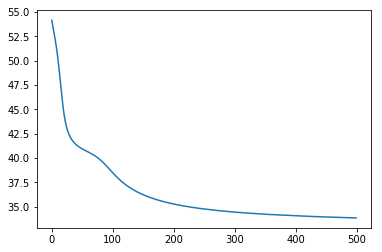

In [47]:
class DSNN(nn.Module):
    def __init__(self,input_size, output_size):
        super(DSNN,self).__init__()
        self.f1 = nn.Linear(input_size,output_size).cuda()
        self.f2 = nn.Linear(input_size,output_size).cuda()
        self.sigmoid = nn.Sigmoid().cuda()
        
    def forward(self,x,h):
        return h*self.sigmoid(self.f1(x)) + (1-h)*self.sigmoid(self.f2(x))

    
data = generateXor_dataset(100)
data_tensor = torch.cat(data[0])
label_tensor = torch.LongTensor(data[1])
trainset= torch.utils.data.TensorDataset(data_tensor,label_tensor)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=10,shuffle=True)
Dsnn = DSNN(data_tensor.size()[1],1)

criterion = nn.MSELoss().cuda()
optimizer = torch.optim.SGD(Dsnn.parameters(),lr=0.01)
nb_epoch = 500
g = torch.FloatTensor([0.5,0.5])
print(g)
global_loss = []
for j in range(nb_epoch):
    running_loss = 0
    for i,data in enumerate(trainloader,0):
        log_p = g
        inputs, labels = data
        labels = labels.type(torch.FloatTensor)
        x = Variable(inputs).cuda()
        y = Variable(labels).cuda()
        # grad a zero
        optimizer.zero_grad()
        out = Dsnn(x,1)
        loss = criterion(out,y) 
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
    global_loss.append(running_loss)

plt.plot(range(len(global_loss)), global_loss)